In [47]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data,get_obs

from sst_envs.utils import cartpole_visualize_point

In [48]:
%matplotlib inline
def draw_obs(env_id, system, ax=None):
    def line_line_cc(x1, y1, x2, y2, x3, y3, x4, y4):
        uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
        if uA >= 0. and uA <= 1. and uB >= 0. and uB <= 1.:
            # intersection
            return True
        # collision free
        return False
    def IsInCollision(x, obc, obc_width=4.):
        I = 10
        L = 2.5
        M = 10
        m = 5
        g = 9.8
        H = 0.5

        STATE_X = 0
        STATE_V = 1
        STATE_THETA = 2
        STATE_W = 3
        CONTROL_A = 0

        MIN_X = -30
        MAX_X = 30
        MIN_V = -40
        MAX_V = 40
        MIN_W = -2
        MAX_W = 2


        if x[0] < MIN_X or x[0] > MAX_X:
            return True

        H = 0.5
        pole_x1 = x[0]
        pole_y1 = H
        pole_x2 = x[0] + L * np.sin(x[2])
        pole_y2 = H + L * np.cos(x[2])

        width = 4
        for i in range(len(obc)):
            for j in range(0, 8, 2):
                x1 = obc[i][j]
                y1 = obc[i][j+1]
                x2 = obc[i][(j+2) % 8]
                y2 = obc[i][(j+3) % 8]
                if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                    return True
        return False
    _obs_list = get_obs(system, env_id)[env_id]#.reshape(-1, 2)
    obs_list = []
    width = 4
    for i in range(len(_obs_list)):
        x = _obs_list[i][0];
        y = _obs_list[i][1];
        obs = np.zeros(8)
        obs[0] = x - width / 2;  obs[1] = y + width / 2;
        obs[2] = x + width / 2;  obs[3] = y + width / 2;
        obs[4] = x + width / 2;  obs[5] = y - width / 2;
        obs[6] = x - width / 2;  obs[7] = y - width / 2;
        obs_list.append(obs)
    obs_i = np.array(obs_list)
        
#     print(obs_i)

    dx = 1
    dtheta = 0.1
    feasible_points = []
    infeasible_points = []
    imin = 0
    imax = int(2*30./dx)
    jmin = 0
    jmax = int(2*np.pi/dtheta)

    for i in range(imin, imax):
        for j in range(jmin, jmax):
            x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
            if IsInCollision(x, obs_i):
                infeasible_points.append(x)
            else:
                feasible_points.append(x)
    feasible_points = np.array(feasible_points)
    infeasible_points = np.array(infeasible_points)
    # print('feasible points')
    # print(feasible_points)
    # print('infeasible points')
    # print(infeasible_points)
    ax.scatter(feasible_points[:,0], feasible_points[:,2], c='azure')
    ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c='slategray')
# env_id = 0
# traj_id = 1802
# system = 'cartpole_obs'
# config = 'default'

# fig, ax = plt.subplots()

# draw_obs(env_id, system, ax)
# data = load_data(system, env_id, traj_id)
# ref_path = data['path']

In [61]:
env = 0
traj_id = 0
goal_radius = 1.5
# setup = "default_norm_subsample0.5"
setup = "default_norm"

# from networks.mpnet_cartpole_obs import MPNet
from networks.mpnet_cartpole_obs_branch import MPNet

mpnet = MPNet(ae_input_size=32, ae_output_size=32, in_channels=1, state_size=4)

# mpnet.load_state_dict(torch.load('output/cartpole_obs/default_norm/mpnet/ep25.pth'.format(setup)))
mpnet.load_state_dict(torch.load('output/cartpole_obs/default_norm/mpnet_branch/ep1000.pth'.format(setup)))

model = "cartpole_obs"

def plan(start_th, goal_th, env_vox, mpnet):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = mpnet(start_goal, env_vox)         
    return sample.clone()

def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    xs, thetas = [], []    
    for s in path:
        xi, _, thetai, _ = s
        xs.append(xi)
        thetas.append(thetai)
    ax.plot(xs, thetas, color)
    ax.scatter(xs, thetas, color='orange')
    plt.xlim(-30, 30)
    plt.ylim(-np.pi,np.pi)
    
    ax.scatter(start[0], start[2], color='red')
    ax.scatter(goal[0], goal[2], color='green')

def distance(point1, point2):
    err_ang = np.abs(point1[2]-point2[2])
    if(err_ang > np.pi):
        err_ang = 2*np.pi-err_ang;
    return np.sqrt(err_ang + ((point1[[0,1,3]] - point2[[0,1,3]]) ** 2).sum())

def wrap_angle(state,scale=1):
    if state[:, 2] > 1:
        state[:, 2] -= 2
    if state[:, 2] < -1:
        state[:, 2] += 2
    return state

def enforce_bounds(state):
    for i in range(len(scale)):
        state[:, i] = torch.clamp(state[:, i], min=-scale[i], max=scale[i])
    return wrap_angle(state)

env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()
env_vox = env_vox_all[env].float().unsqueeze(0)
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']

<ipython-input-48-2c916612166e>:4: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
<ipython-input-48-2c916612166e>:5: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


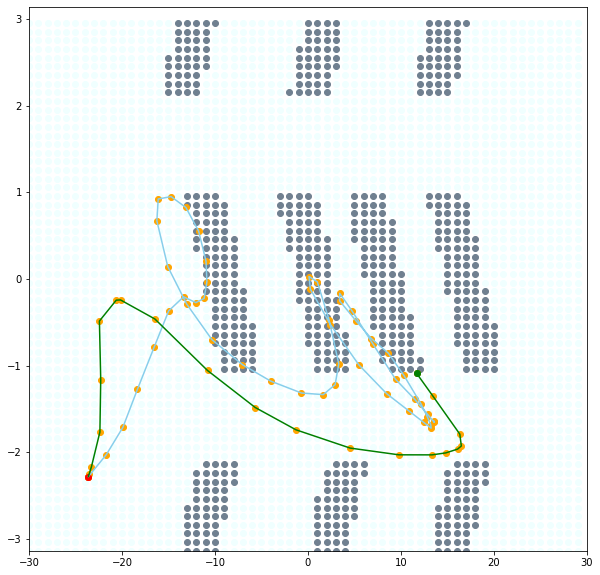

In [65]:
%matplotlib inline
# mpnet.train()
mpnet.eval()
path = []
start = ref_path[0].copy()
goal = ref_path[-1].copy()
# goal = ref_sg[-1].copy()
scale = np.array([30, 40, np.pi, 2])
normalize = lambda state: state/scale
denormalize = lambda state: state*scale

start, goal = map(normalize, [start, goal])

state_th = torch.from_numpy(start).unsqueeze(0).float()
goal_th = torch.from_numpy(goal).unsqueeze(0).float()

path.append(denormalize(state_th[0].numpy()))
for i in range(50):
    sample = plan(state_th, goal_th, env_vox, mpnet)
    state_th = sample[:, :4].clone()
    state_th = enforce_bounds(state_th)
    path.append(denormalize(state_th[0].numpy()))
#     print(state_th)
fig1, ax1 = plt.subplots(figsize=(10,10))
draw_obs(env, model, ax1)
path_from_data = ref_path.copy()
# path_from_data #/= np.array([30, 40, np.pi, 2])
# path_from_data #/= np.array([30, 40, np.pi, 2])
visualize(path, ref_path[0], ref_path[-1], ax1)
visualize(path_from_data, path_from_data[0], path_from_data[-1], ax1, color='green')


<ipython-input-48-2c916612166e>:4: RuntimeWarning: divide by zero encountered in double_scalars
  uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
<ipython-input-48-2c916612166e>:5: RuntimeWarning: divide by zero encountered in double_scalars
  uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))


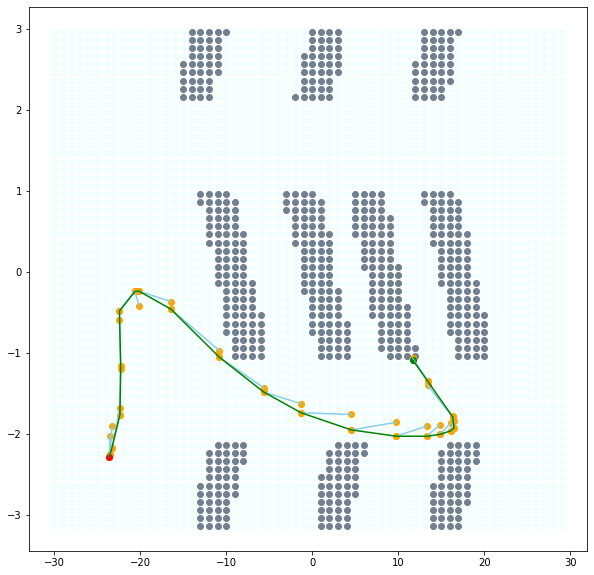

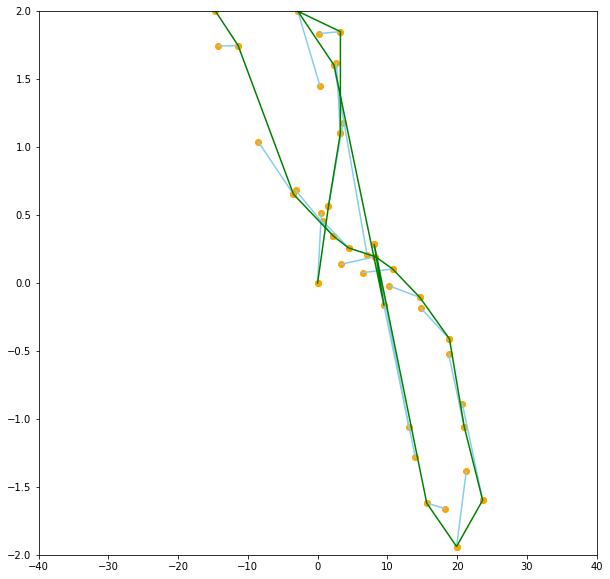

In [64]:
%matplotlib inline

fig2, ax2 = plt.subplots(figsize=(10,10))
draw_obs(env, model, ax2)


show_vel = True
if show_vel:
    fig3, ax3 = plt.subplots(figsize=(10,10))


for i in range(len(ref_path)-1):
    current_start = torch.from_numpy(normalize(ref_path[i])).unsqueeze(0)
    sample = plan(current_start,
                  goal_th, 
                  env_vox,
                  mpnet)
    state_th = sample[:, :4].clone()
    state_th = denormalize(enforce_bounds(state_th).numpy())
    state_th[0, 0] = ref_path[i+1, 0]
    
    current_start = denormalize(current_start.numpy())
    ax2.plot([current_start[0, 0], state_th[0, 0]], [current_start[0, 2], state_th[0, 2]], c='skyblue')
    ax2.scatter(current_start[0, 0], current_start[0, 2], color='orange')
    ax2.scatter(state_th[0, 0], state_th[0, 2], color='orange')
    if show_vel:
        ax3.plot([current_start[0, 1], state_th[0, 1]], [current_start[0, 3], state_th[0, 3]], c='skyblue')
        ax3.scatter(current_start[0, 1], current_start[0, 3], color='orange')
        ax3.scatter(state_th[0, 1], state_th[0, 3], color='orange')
path_from_data = ref_path.copy()
visualize(path_from_data, path_from_data[0], path_from_data[-1], ax2, color='green')

if show_vel:
    ax3.plot(path_from_data[:, 1], path_from_data[:, 3], color='green')
    ax3.scatter(path_from_data[:, 1], path_from_data[:, 3], color='orange')
    ax3.set_xlim(-40, 40)
    ax3.set_ylim(-2, 2)